# makeGeneScores

Caleb Lareau has provided this script to make a gene by cell feature matrix where the resulting feature matrix contains peak intensity values weighted by the number of ATAC regions for a given annotated promoter region. **Here we apply it to the 2018 Buenrostro data for 2,034 single cells. This is the first vignette of this method**

### Installation and R Library loading

In [3]:
# install dependencies
devtools::install_github("caleblareau/BuenColors")

Skipping install of 'BuenColors' from a github remote, the SHA1 (6f62ace8) has not changed since last install.
  Use `force = TRUE` to force installation


In [5]:
# libraries
library(GenomicRanges)
library(SummarizedExperiment)
library(data.table)
library(dplyr)
library(BuenColors)
library(Matrix)

### Importing peaks to generate a genes by peaks matrix

In [6]:
set.seed(1)

In [7]:
# import gene bodies; restrict to TSS
gdf <- read.table("./data/hg19-tss.bed", stringsAsFactors = FALSE)
tss <- data.frame(chr = gdf$V1, gene = gdf$V4, stringsAsFactors = FALSE)
tss$tss <-  ifelse(gdf$V5 == "+", gdf$V3, gdf$V2)
tss$start <- ifelse(tss$tss - 50000 > 0, tss$tss - 50000, 0)
tss$stop <- tss$tss + 50000

tss_idx <- makeGRangesFromDataFrame(tss, keep.extra.columns = TRUE)

In [8]:
# import ATAC peaks

# updating with the new peaks.bed file 
adf <- data.frame(fread('/data/pinello/PROJECTS/2019_03_scATAC/Datasets/Buenrostro_2018/peaks/merged_sc-bams/combined.sorted.merged.bed')); colnames(adf) <- c("chr", "start", "end")
#adf <- data.frame(fread("/data/pinello/PROJECTS/2019_03_scATAC/Datasets/Buenrostro_2018/GSE96769_PeakFile_20160207.bed")); colnames(adf) <- c("chr", "start", "end")
adf$mp <- (adf$start + adf$end)/2
atacgranges <- makeGRangesFromDataFrame(adf, start.field = "mp", end.field = "mp")

In [9]:
# find overlap between ATAC peaks and Ranges linker
ov <- findOverlaps(atacgranges, tss_idx) #(query, subject)

Don't know how to automatically pick scale for object of type table. Defaulting to continuous.
Don't know how to automatically pick scale for object of type table. Defaulting to continuous.


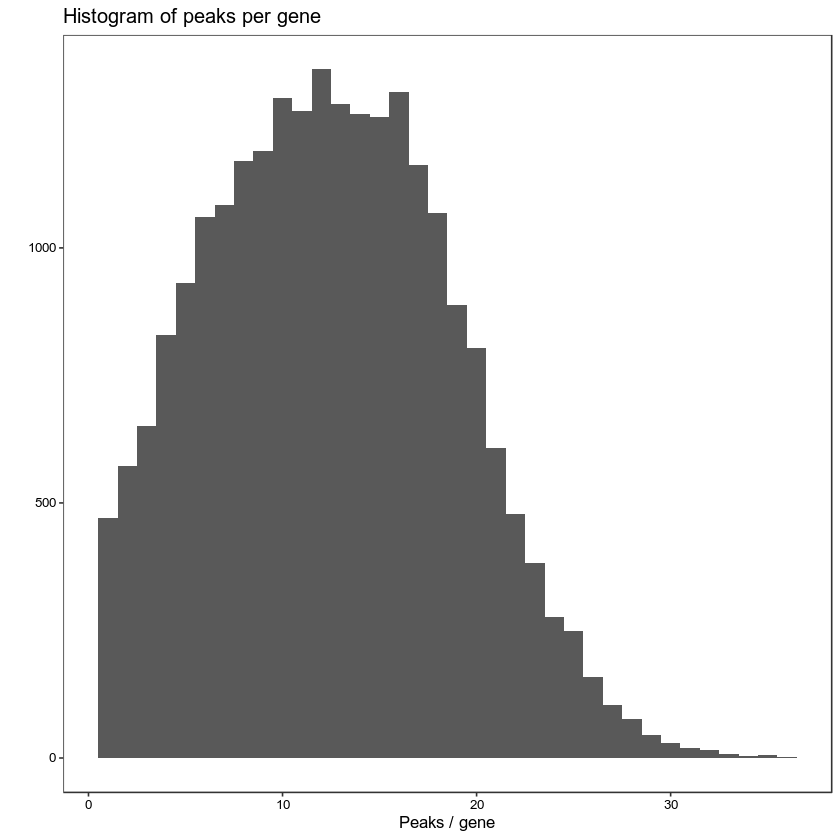

In [10]:
# plot a histogram showing peaks per gene
p1 <- qplot(table(subjectHits(ov)), binwidth = 1) + theme(plot.subtitle = element_text(vjust = 1), 
                                                          plot.caption = element_text(vjust = 1)) +
  labs(title = "Histogram of peaks per gene",  x = "Peaks / gene") + pretty_plot()
cowplot::ggsave(p1, file = "./output/histo1.png", width = 5, height = 4)
p1

In [11]:
# calculate distance decay for the weights
dist <- abs(mcols(tss_idx)$tss[subjectHits(ov)] - start(atacgranges)[queryHits(ov)])
exp_dist_model <- exp(-1*dist/5000)

### Generating a counts matrix

In [12]:
# prepare an outcome matrix
m <- Matrix::sparseMatrix(i = c(queryHits(ov), length(atacgranges)),
                          j = c(subjectHits(ov), length(tss_idx)),
                          x = c(exp_dist_model,0))

# check the pre-filtering dimensions
bef <- dim(m)
cat("The dimensions of the outcome matrix are",bef ,"before filtering.  
")

# filter some genes that have no hits 
colnames(m) <- gdf$V4 # gene name
m <- m[,which(Matrix::colSums(m) != 0)]

# check dimensions to see the filtering
aft <- dim(m)
cat('The dimensions of the outcome matrix are', aft ,"after filtering.")

The dimensions of the outcome matrix are 237450 23938 before filtering.  
The dimensions of the outcome matrix are 237450 23356 after filtering.

#### The following two cells contain the bash code that was used to process the single cell bam files to the counts matrix

The user needs to choose the following inputs: 
- bampath = the folder containing your single-cell bam files
- in the `bedtools coverage` function, the user must specify `-a [input]` to be the bed file containing the ATACseq peaks. This bedfile must match the bedfile from which you generated `atacranges` above.

```
#!/bin/bash

source activate ATACseq_preprocess
bampath=/data/pinello/PROJECTS/2019_03_scATAC/Datasets/Buenrostro_2018/sc-bams/
dirlist=(`ls $bampath*.bam`)
mkdir -p count_reads_output
for FILE in ${dirlist[*]}
do
	CELL=$(echo $(basename $FILE) | awk -F "." '{print $1}')
	echo $CELL
	bedtools coverage -a /data/pinello/PROJECTS/2019_03_scATAC/Datasets/Buenrostro_2018/GSE96769_PeakFile_20160207.bed -b $FILE > ./count_reads_output2/$CELL.txt
done
```

- `output` = a .txt file for each bam file/cell containing the output of bedtools coverage

#### bash code to loop through a folder and for each file, take the 6th column and create a new column
>for i in ./count_reads_output/*txt; do cut -f 15 $i > $i.read.counts; done
>
>`function:` loops through the above created .txt files and creates a new file, extracting the column containing the >read count for each peak.
>
>`user parameter` for the  `cut` function, change `-f` to the column containing the peaks - this may vary depending on the type of bedfile you are starting with. 
>
>`output` = a `*.read.counts` file for each file originally in your output folder. 
>
#### past each column together, making a peak x cell matrix 
>paste ./count_reads_output/*counts > >/data/pinello/PROJECTS/2019_03_scATAC/Methods/Scasat/makeGeneScores/counts_matrix.txt
>
>`function:` takes all of the `.read.counts` files that you just created and pastes them together to create the desired peaks x cell matrix. At this point, it would be good to perform a quality check by eye to ensure the proper formation of your counts matrix.


In [13]:
# import counts
counts <- data.matrix(data.frame(fread("./counts_matrix.txt")))

In [14]:
# inspection of counts matrix
dim(counts)
head(counts)

[1] 237450   2034

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V2025,V2026,V2027,V2028,V2029,V2030,V2031,V2032,V2033,V2034
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,8,2,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### Matrix Multiplication to generate Gene Scores Matrix

In [15]:
geneScores <- t(m) %*% counts #transpose matrix m and multiply it by counts

### Exporting the resulting matrix in two pieces

In [16]:
write.table(data.frame(data.matrix(geneScores)), row.names = FALSE, col.names = TRUE, 
            sep = "\t", quote = FALSE, file = "./output/bmControl-louvain_rawGeneScores.tsv")
write.table(data.frame(rownames(geneScores)), row.names = FALSE, col.names = FALSE, 
            sep = "\t", quote = FALSE, file = "./output/bmControl-louvain_geneAnnotations.tsv")

### Visualization of Output

In [42]:
rawGeneScores = fread('./output/bmControl-louvain_rawGeneScores.tsv')
geneAnnotations = fread("./output/bmControl-louvain_geneAnnotations.tsv", header = FALSE)

In [43]:
head(rawGeneScores) # multiplication product of read count x sparse matrix of peaks in a gene = read count/score per gene

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V2025,V2026,V2027,V2028,V2029,V2030,V2031,V2032,V2033,V2034
0,0,0,0,3.5173025,0.0000000000,0,0,0.002119759,0.002119759,⋯,0.12725846,0.08449585,0.0000000000,0.7593362,0.27851055,0.2607732,0.1728171,0.08564297,0.0000000000,0.261122
0,0,0,0,0.8515427,0.0001922233,0,0,0.012477092,0.011323752,⋯,0.05011447,0.45137680,0.0003844466,4.0010690,1.49145541,1.3773481,0.9231889,0.03847351,0.0009611165,1.395875
0,0,0,0,0.0000000,0.0000000000,0,0,0.000000000,0.000000000,⋯,0.00000000,0.00000000,0.0000000000,0.0000000,0.00000000,0.0000000,0.0000000,0.00000000,0.0000000000,0.000000
0,0,0,0,0.0000000,0.0000000000,0,0,0.000000000,0.000000000,⋯,0.00000000,0.00000000,0.0000000000,0.0000000,0.00000000,0.0000000,0.0000000,0.00000000,0.0000000000,0.000000
0,0,0,0,0.0000000,0.0000000000,0,0,1.102242985,0.000000000,⋯,0.00000000,0.00000000,0.0000000000,0.0000000,0.05668459,0.0000000,0.0000000,0.00000000,0.0000000000,0.000000
0,0,0,0,0.0000000,0.0000000000,0,0,1.028135719,0.000000000,⋯,0.00000000,0.00000000,0.0000000000,0.0000000,0.05287351,0.0000000,0.0000000,0.00000000,0.0000000000,0.000000


In [44]:
countFileFolder = './count_reads_output'
cellNamePattern = '.txt$'
countFiles = list.files(path=countFileFolder, pattern = cellNamePattern, full.names=TRUE)
head(countFiles)

[1] "./count_reads_output/BM1077-CLP-Frozen-160106-13.txt"
[2] "./count_reads_output/BM1077-CLP-Frozen-160106-14.txt"
[3] "./count_reads_output/BM1077-CLP-Frozen-160106-2.txt" 
[4] "./count_reads_output/BM1077-CLP-Frozen-160106-21.txt"
[5] "./count_reads_output/BM1077-CLP-Frozen-160106-27.txt"
[6] "./count_reads_output/BM1077-CLP-Frozen-160106-3.txt"

In [45]:
CellNames = list.files(path=countFileFolder, pattern = cellNamePattern)

In [46]:
CellNames = gsub("*.txt","",CellNames)
length(CellNames)
head(CellNames)

[1] 2034

[1] "BM1077-CLP-Frozen-160106-13" "BM1077-CLP-Frozen-160106-14"
[3] "BM1077-CLP-Frozen-160106-2"  "BM1077-CLP-Frozen-160106-21"
[5] "BM1077-CLP-Frozen-160106-27" "BM1077-CLP-Frozen-160106-3"

In [47]:
colnames(geneAnnotations) = 'Gene'
colnames(rawGeneScores) = CellNames

In [48]:
FeatureMatrix = cbind(geneAnnotations, rawGeneScores)

In [49]:
head(FeatureMatrix) # probably need to add cell labels 

Gene,BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-27,BM1077-CLP-Frozen-160106-3,BM1077-CLP-Frozen-160106-36,BM1077-CLP-Frozen-160106-42,BM1077-CLP-Frozen-160106-44,⋯,singles-PB1022-mono-160128-81,singles-PB1022-mono-160128-82,singles-PB1022-mono-160128-83,singles-PB1022-mono-160128-84,singles-PB1022-mono-160128-85,singles-PB1022-mono-160128-86,singles-PB1022-mono-160128-89,singles-PB1022-mono-160128-90,singles-PB1022-mono-160128-95,singles-PB1022-mono-160128-96
A1BG,0,0,0,0,3.5173025,0.0000000000,0,0,0.002119759,⋯,0.12725846,0.08449585,0.0000000000,0.7593362,0.27851055,0.2607732,0.1728171,0.08564297,0.0000000000,0.261122
A1BG-AS1,0,0,0,0,0.8515427,0.0001922233,0,0,0.012477092,⋯,0.05011447,0.45137680,0.0003844466,4.0010690,1.49145541,1.3773481,0.9231889,0.03847351,0.0009611165,1.395875
A1CF,0,0,0,0,0.0000000,0.0000000000,0,0,0.000000000,⋯,0.00000000,0.00000000,0.0000000000,0.0000000,0.00000000,0.0000000,0.0000000,0.00000000,0.0000000000,0.000000
A2LD1,0,0,0,0,0.0000000,0.0000000000,0,0,0.000000000,⋯,0.00000000,0.00000000,0.0000000000,0.0000000,0.00000000,0.0000000,0.0000000,0.00000000,0.0000000000,0.000000
A2M,0,0,0,0,0.0000000,0.0000000000,0,0,1.102242985,⋯,0.00000000,0.00000000,0.0000000000,0.0000000,0.05668459,0.0000000,0.0000000,0.00000000,0.0000000000,0.000000
A2M-AS1,0,0,0,0,0.0000000,0.0000000000,0,0,1.028135719,⋯,0.00000000,0.00000000,0.0000000000,0.0000000,0.05287351,0.0000000,0.0000000,0.00000000,0.0000000000,0.000000


In [50]:
# final export of feature matrix to the FeatureMatrix folder
write.table(file = '/data/pinello/PROJECTS/2019_03_scATAC/FeatureMatrix/FM_makeGeneScores_Buenrostro_2018.tsv',FeatureMatrix,col.names = TRUE,row.names = TRUE,quote = FALSE,sep="\t")